<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/DTW-SOM/DTW_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [30]:
## éste paquete utiliza mini som por debajo
!pip install DtwSom


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import dtwsom   # Librería para utilizar el modelo DTW-SOM
import os
import numpy as np  
import pandas as pd
import datetime
import pickle # Librería que serializa y deserializa una estructura de objetos Python
from math import sqrt

from sklearn.preprocessing import MinMaxScaler # función para el escalar los datos
from sklearn.cluster import KMeans 
from sklearn.metrics import r2_score 

from tslearn.metrics import dtw # Distancia DTW (dynamic time wrapping)


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from matplotlib import cm

from scipy.spatial.distance import cdist # calcula distancias Manhattan(cityblock)



In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Cargar repositorio

Este código carga todo el repositorio GitHub en una carpeta en el Google cola. Funciona impecable cuando se tienen muchos archivos que se quieren cargar.

In [33]:
!git clone https://github.com/castudil/som-lstm.git

Cloning into 'som-lstm'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 197 (delta 78), reused 73 (delta 2), pack-reused 0
Receiving objects: 100% (197/197), 20.48 MiB | 10.61 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [34]:
cd som-lstm

/content/som-lstm/som-lstm


# Funciones

In [35]:
def perturbation(df, col=0, mu=0, sigma=0.1):

  """
    Funcion que perturba una columna de un dataframe, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
        df : DataFrame 
          DataFrame de los datos para perturbar
        col : int
          columna del DataFrame que sera perturbada
        mu: float
          mean
        sigma: float
          desviacion estandar
  """
  np.random.seed(11)
  df = df.copy() # copia el dataframe para evitar que se modifique el dataframe original

  cardinality = df.shape[0] # numero de instancias del dataset

  # Toma muestras aleatorias de una distribución normal
  perturbacion = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))

  columns_name  = df.columns # nombres de las columnas

  # Suma las muestras aleatorias a la columna seleccionada y pasa esta suma al dataset copiado.
  df[columns_name[col]] = df[columns_name[col]] + perturbacion  

  return df

In [36]:
def perturbationByInstance(instance, num_muta=100, mu=0, sigma=0.1):
    """
    Función que genera perturbaciones de una instancia dada, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
    instance : np.array
        instancia que será perturbada
    num_muta : int
        cantidad de perturbaciones a generar
    mu: float
        mean
    sigma: float
        desviación estándar
    """
    df =[] # inicia el array 

    cardinality = instance.shape[0] # numero de columnas de la instancia

    # Genera n mutaciones de la instancia dada.
    for i in range(num_muta):
        # Toma muestras aleatorias de una distribución normal
        noise = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))
        # suma el ruido a las instancia en particular
        element = np.array(instance + noise) 
        # Agrega la instancia perturbada a lista de instancias mutadas
        df.append(element)

    return np.array(df)

In [37]:
def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return np.sqrt(np.dot(x, x.T))

In [38]:
def ts_train_test_normalize(all_data, time_steps, for_periods, name_target, start_date_train=None, end_date_train=None, start_date_test=None, end_date_test=None):
    '''
    input: 
        all_data: dataframe 
        time_steps: tamaño de la ventana para obtener una predicción
        for_periods: cantidad de datos a predecir 
        start_date_train: fecha de inicio de los datos de entramiento
        end_date_train: fecha de final de los datos de entramiento
        start_date_test: fecha de inicio de los datos de prueba
        end_date_test: fecha de final de los datos de prueba
        output:
        X_train, y_train: data de [start_date_train - end_date_train]
        X_test:  data de [start_date_test - end_date_test]
        sc:      instancia del objeto MinMaxScaler (Escala los datos de entrenamiento)
    '''


    start_date_train =  start_date_train if start_date_train else all_data.index[0]
    end_date_test =  end_date_test if end_date_test else all_data.index[len(all_data)-1]

    # crear un conjunto de entrenamiento y prueba
    ts_train = all_data[start_date_train : end_date_train].iloc[:,0:1].values
    ts_test  = all_data[start_date_test : end_date_test].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Escalar los datos en el rango (0,1)
    #sc = MinMaxScaler(feature_range=(0,1))
    #ts_train_scaled = sc.fit_transform(ts_train)

    # Crear datos de entrenamiento de s muestras y t pasos de tiempo
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        # Añade la ventana de t pasos de tiempo para el conjunto de entrenamiento x
        X_train.append(ts_train[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de entrenamiento y 
        y_train.append(ts_train[i:i+for_periods,0])
    # Convierte los datos de entramiento en arreglos de numpy
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reestructura X_train a 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Escala los datos para el conjunto de datos de prueba 
    inputs = pd.concat((all_data[name_target][start_date_train : end_date_train], all_data[name_target][start_date_test : end_date_test]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1) # Convertir en array cada valor del array. Ex: [1,2,3] -> [[1],[2],[3]]
    #inputs  = sc.transform(inputs) # Escala los datos en el rango (0,1)

    # Crea los datos de prueba X_test de s muestras y t pasos de tiempo
    X_test, y_test = [], []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        # Añade la ventana de t pasos de tiempo para el conjunto de prueba X
        X_test.append(inputs[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de prueba y
        y_test.append(inputs[i:i+for_periods,0])
    # Convierte los datos de prueba en arreglos de numpy
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reestructura X_test a 3D [samples, timesteps, features]
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, y_test

# Dataset PM25

Carga el conjunto de datos de material particulado menor a 2.5 micras de 9 regiones, del valle central de Chile. 

In [39]:
path = 'data/' # use your path
cities = ['chillan','curico','linares','los_angeles','osorno','puerto_montt','rancagua','san_fernando','talca'];
li = []
for i in cities:
  filename=path+i+'.csv'
  print('loading: '+filename)
  df = pd.read_csv(filename, index_col=None, header=0)
  # Convert the date column to a datestamp type
  df['date'] = pd.to_datetime(df['date'])
  # Set the date column as the index of your DataFrame meat
  df['city']=i
  df = df.set_index('date')
  #print(df.head(5))
  li.append(df)

print('consolidating into a single data frame.')
frame = pd.concat(li, axis=0, ignore_index=False)
print('displaying a random sample.')
#print(frame.sample(n = 5))
print(frame.describe())
print(frame.index.min())
print(frame.index.max())

loading: data/chillan.csv
loading: data/curico.csv
loading: data/linares.csv
loading: data/los_angeles.csv
loading: data/osorno.csv
loading: data/puerto_montt.csv
loading: data/rancagua.csv
loading: data/san_fernando.csv
loading: data/talca.csv
consolidating into a single data frame.
displaying a random sample.
                PM25
count  394623.000000
mean       25.050619
std        48.755149
min         0.000000
25%         6.000000
50%        12.000000
75%        25.000000
max      1505.000000
2016-01-01 01:00:00
2020-12-31 23:00:00


Para aprobar en primera instancia el algoritmo nos centraremos solo en la ciudad de Talca.

In [40]:
# filtered for city
df_talca = frame.loc[frame['city'] == 'talca']
del(df_talca['city'])
df_talca.shape

(43847, 1)

Se puede observar que el conjunto para la ciudad de Talca es de 43847 instancias, que representan el PM2.5 por hora entre los años 2016 y 2022. Este sera transformado en un formato de ventanas de 24 horas, Quedando con el formato (n, 24) donde n representa  a las días entre las fechas indicadas anteriormente.

el paper DTW SOM [CITA] muestra un procedimineto similar, donde se hacen ventanas de 24 horas.

corta todos los datos a series de tiempo de 24 horas de igual dimension. las ventanas no se solapan.


In [41]:
def create_window_data(df):
  data = []
  index= []
  for i in range(0, int(df.size /24) ):
    index.append(np.array(df.index[i*24:i*24+24]).reshape(1,24)[0])
    data.append(df.values[i*24:i*24+24].reshape(1,24)[0])

  data = np.array(data) ## serie de tiempo
  index = np.array(index) ### este indice identifica el dia

  return (data, index)

data_talca, index_talca = create_window_data(df_talca)

data_talca.shape

(1826, 24)

Las observaciones al ser transformada al formato de ventanas de 24 horas, quedaron con un total de 1826 días para analizar.

In [42]:
index_talca[930]

array(['2018-07-19T01:00:00.000000000', '2018-07-19T02:00:00.000000000',
       '2018-07-19T03:00:00.000000000', '2018-07-19T04:00:00.000000000',
       '2018-07-19T05:00:00.000000000', '2018-07-19T06:00:00.000000000',
       '2018-07-19T07:00:00.000000000', '2018-07-19T08:00:00.000000000',
       '2018-07-19T09:00:00.000000000', '2018-07-19T10:00:00.000000000',
       '2018-07-19T11:00:00.000000000', '2018-07-19T12:00:00.000000000',
       '2018-07-19T13:00:00.000000000', '2018-07-19T14:00:00.000000000',
       '2018-07-19T15:00:00.000000000', '2018-07-19T16:00:00.000000000',
       '2018-07-19T17:00:00.000000000', '2018-07-19T18:00:00.000000000',
       '2018-07-19T19:00:00.000000000', '2018-07-19T20:00:00.000000000',
       '2018-07-19T21:00:00.000000000', '2018-07-19T22:00:00.000000000',
       '2018-07-19T23:00:00.000000000', '2018-07-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [43]:
data_talca[930] ###TODO cambiar a nombre significativo

array([35., 21., 14., 14., 14., 12., 12., 14., 27., 41., 35., 39., 43.,
       45., 28., 28., 40., 39., 59., 60., 55., 52., 58., 34.])

Se puede observar como estaría conformada una ventana de 24 horas de nuestros datos.

# Inicializacion de parametros para SOM

Una regla general para establecer el tamaño de la rejilla para una tarea de reducción de la dimensionalidad es que debe contener 5*raiz(N) neuronas donde N es el número de muestras del conjunto de datos a analizar. 

Por ejemplo, si su conjunto de datos tiene 150 muestras, 5*sqrt(150) = 61,23 por lo que un mapa de 8 por 8 debería funcionar bien.

Recomendación entrega por el paquete de MiniSOm (https://github.com/JustGlowing/minisom/blob/b18aa5cb293ab99c2d77f37d312b12d7d93d2124/minisom.py#L528)

In [44]:
round(sqrt(5*sqrt(len(data_talca)))) ### example of the calculus of the grid size

15

El experimento presenta una comparación de un SOM tradicional con una variante que utiliza DTW, llamada DTW-SOM. Se compara los dos métodos con los mismos datos y con configuraciones similares. Se espera obtener que la version que utiliza DTW tenga un menor error de cuantificación, puesto que, en los análisis realizados por [Paper DTW-SOM](https://www.nature.com/articles/s41598-021-03515-1) se obtenían mejores resultados al encontrar similitudes en datos de series temporales. 

La comparación es necesaria para proponer un método que represente mejor los datos de entradas con el fin de obtener una mejor preservación de la topología, probando la robustez de los modelos propuestos.

In [45]:
# Inicializa los parametros de SOM
num_neurons = round(sqrt(5*sqrt(len(data_talca)))) # the grid size
sigma = 3 # radio
lr = 0.5 # tasa de aprendizaje
seed = 11 # semilla para repetir los resultados
num_iter = 5000 # numero de iteraciones para entrenar al SOM
input_len = data_talca.shape[1] #Largo de la entrada

# Parámetros específicos SOM estándar
dist = 'euclidean' # Distancia utilizada 
neighborhood_funct = 'gaussian' # funcion de vencidad 

# Parámetros específicos de DTW-SOM
gl_const="sakoe_chiba"
scr=60


#Modelos SOM

## DTW-SOM

Carga el modelo DTW-SOM ya entrenado con los parametros indicados en el punto anterior.

Entrena a DTW-SOM en el caso de no tener un modelo pre-entrenado.


In [ ]:
if os.path.exists('DTW-SOM/dtw_som_15.pkl'): # Busca modelo pre-entrenado en los archivos
    with open('DTW-SOM/dtw_som_15.pkl', 'rb') as f: # abre el modelo pre-entrenado
        dtw_som = pickle.load(f) # Carga el modelo pre-entrenado
else: # Si no encuentra el archivo, crea y entrena el modelo DTW-SOM 
    dtw_som = dtwsom.DtwSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                        random_seed=seed, gl_const=gl_const, scr=scr) # Inicializa el modelo
    dtw_som.pca_weights_init(data_talca) # Inicializa los pesos con PCA
    dtw_som.train_batch(data_talca, num_iter, verbose=True) # Entena el modelo 

In [ ]:
weights = dtw_som.get_weights() # Obtiene los pesos del modelo entrenado 
print("cuantificacion del error: ",dtw_som.quantization_error(data_talca)) 

cuantificacion del error:  28.437137390020354


### Save Model

Guarda el modelo DTW-SOM en el archivo "dtw_som.pkl" para no tener que volver a entrenar el modelo.

In [ ]:
## Save the model so that you do not need to train it again
with open('dtw_som_15.pkl', 'wb') as f:
    pickle.dump(dtw_som,f)

### Agrupación 

Al agrupar en 4 cluster las series temporales, se espera encontrar patrones y caracteristicas en las series similares. Construyendo agrupaciones que representan los periodos estacionales verano, invierno, primavera y otoño. 

In [ ]:
KMeans_X = np.stack((np.array(weights)).reshape(num_neurons*num_neurons, 24))
KMeans_all = KMeans(n_clusters=4, random_state=11).fit(KMeans_X)


In [ ]:
def graph_cluster(data,W,num_neurons, maxylim=150):
    plt.figure(figsize=(20, 20))
    norm = Normalize(vmin=0, vmax=3, clip=True)
    cmap = ListedColormap(["#f1faee", '#e63946', "#f9c74f", '#a8dadc'])
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(num_neurons):
        for j in range(num_neurons):
            ax = plt.subplot(num_neurons, num_neurons, i*num_neurons + 1+j)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_ylim((0,maxylim/5))
            plt.plot(W[ i, j, :].T, color= 'black')
            ax.set_facecolor(mapper.to_rgba(data.labels_[i*num_neurons +j]))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

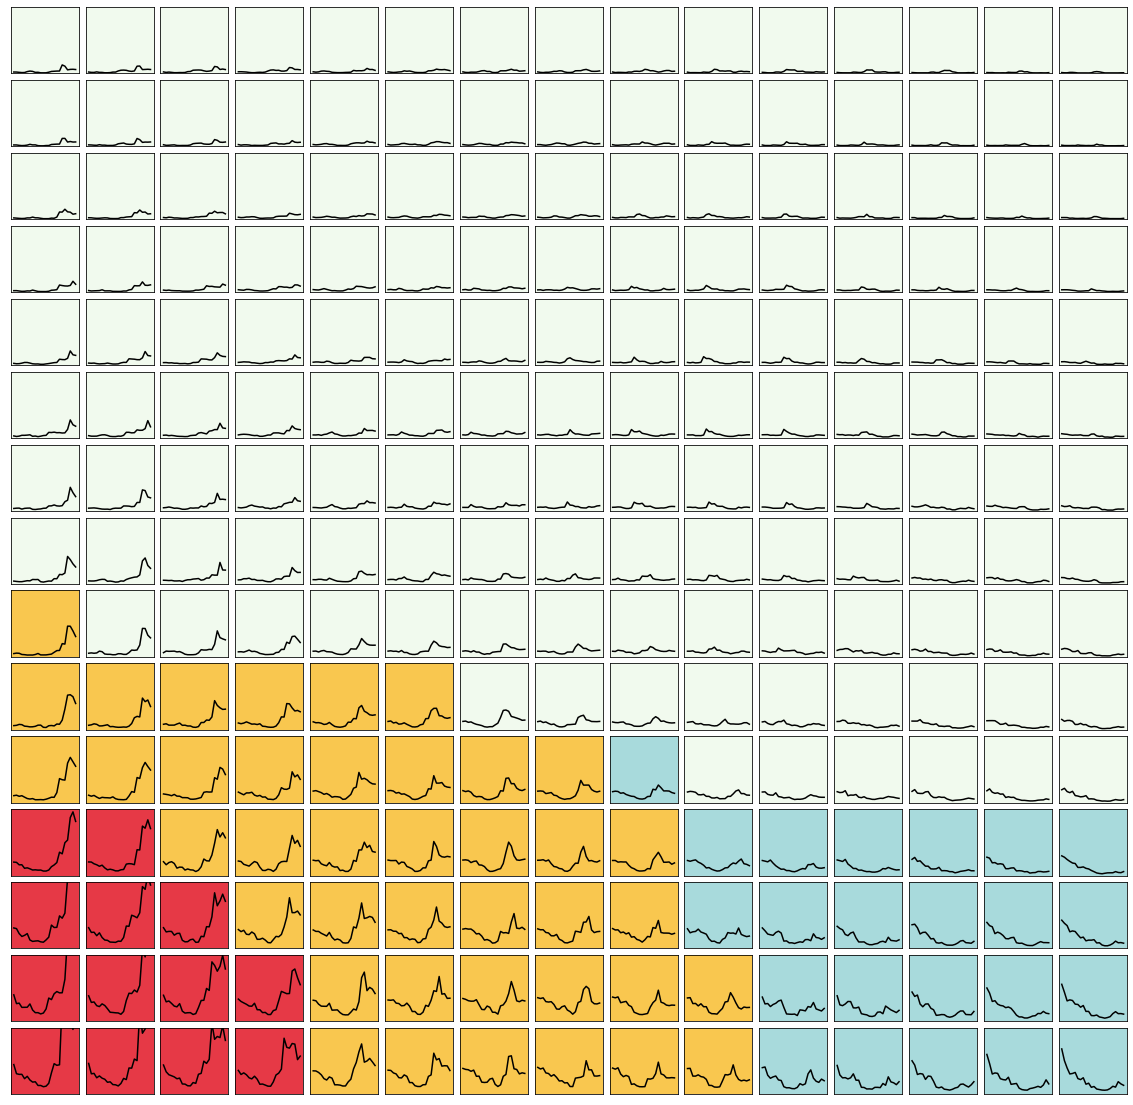

In [ ]:
graph_cluster(data=KMeans_all,W=weights,num_neurons=num_neurons, maxylim=np.max(data_talca), ["#f1faee", '#e63946', "#f9c74f", '#a8dadc'])

Al observar los cluster obtenidos podemos encontrar series que presentan una curva más pronunciada, indicando que el PM25 es mayor para esa zona color roja, por lo que, se puede inducir que ésta es representativa al periodo de Invierno. De esta manera podemos identificar otras estaciones, como la zona amarilla, en la cual tenemos series con curvas menos pronunciada, pero con montes significativos que podemos asociarlo al otoño. por otro lado la zona celeste es similar a la primavera, donde la contaminación va reduciendo a medida que vamos acercándonos al verano. Los series que presentan un patron más aplanado son asociadas a bajas concentraciones de pm25, el cual podemos encontrar en verano, siendo representados en la agrupación por la zona blanca. Kmeans consigue agrupar las series que presentan patrones de pm25 similares para los diferentes periodos de tiempo.

### Visualización de los pesos 

TODO quitar eje x y eje Y ya que no aporta informacion

In [ ]:
def graph_weights(W, num_neurons, save_img=False):
    plt.figure(figsize=(15, 16))

    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.title("PM25 " +"- "+str(i+1)+" hour")
        plt.pcolor(W[:,:,i].T,cmap='coolwarm')
        plt.colorbar()
    plt.tight_layout()
    if save_img:
        plt.savefig('images/som_weights.png')
    plt.show()


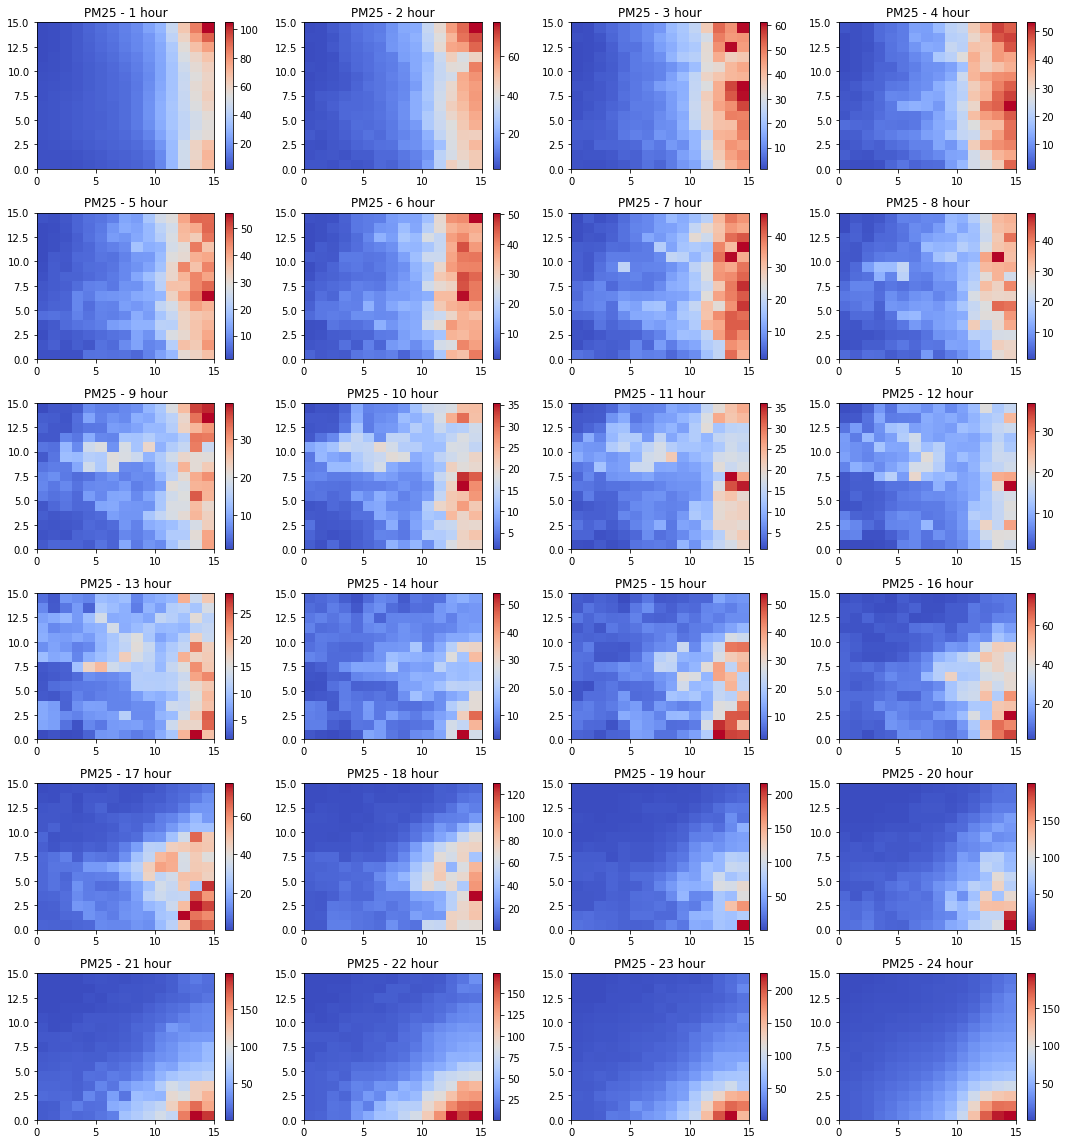

In [ ]:
graph_weights(weights, num_neurons)

Se muestran los pesos por hora de las ventanas entregadas al SOM para el entrenamiento. Estos pesos presentan una escala propia para cada hora. 

Tambien se puede observar que para los horarios entre las horas 19 pm y 01 am, presentan una escala con un nivel del PM25 mayor a 150 en dichos horarios. Lo que es correcto representativo de las epocas de inviernos donde los picos de contaminación estan en su maximo.   

In [ ]:
def graph_u_matrix(data):
    plt.figure(figsize=(8, 8))
    plt.pcolor(data, cmap='coolwarm', alpha=.35)
    plt.colorbar()

    colors = ['C3', 'C2', "C1"]

    #plt.legend(loc='upper right')
    plt.grid()
    #plt.savefig('resulting_images/som_seed.png')
    plt.show()

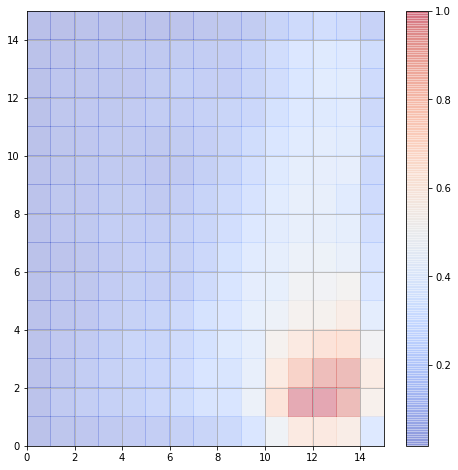

In [ ]:
graph_u_matrix(dtw_som.distance_map().T)

Se observa que en la esquina inferior derecha se encuentran los dias de contaminacion con PM25 alto. Ademas, observamos que la zona señalada esta distanciado de las otras zonas, que presentan una distancia menor entre ellas. 

## SOM - standard

In [ ]:
if os.path.exists('DTW-SOM/som_standard_15.pkl'): # Busca modelo pre-entrenado en los archivos
  with open('DTW-SOM/som_standard_15.pkl', 'rb') as f:  # abre el modelo pre-entrenado
    som_standard = pickle.load(f) # Carga el modelo pre-entrenado
else: # Si no encuentra el archivo, crea y entrena el modelo DTW-SOM 
  # Inicializa SOM
  som_standard = dtwsom.MiniSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                      random_seed=seed) # Inicializa el modelo
  som_standard.pca_weights_init(data_talca) # Inicializa los pesos con PCA
  som_standard.train_batch(data_talca, num_iter, verbose=True) # Entrada SOM


In [ ]:
with open('DTW-SOM/som_standard_15.pkl', 'rb') as f:
    som_standard = pickle.load(f)

In [ ]:
weights = som_standard.get_weights() # Obtiene los pesos
print("cuantificacion del error: ",som_standard.quantization_error(data_talca))

cuantificacion del error:  38.27610008543876


## Agrupación

In [ ]:
KMeans_X = np.stack((np.array(weights)).reshape(num_neurons*num_neurons, 24))
KMeans_all = KMeans(n_clusters=4, random_state=11).fit(KMeans_X)

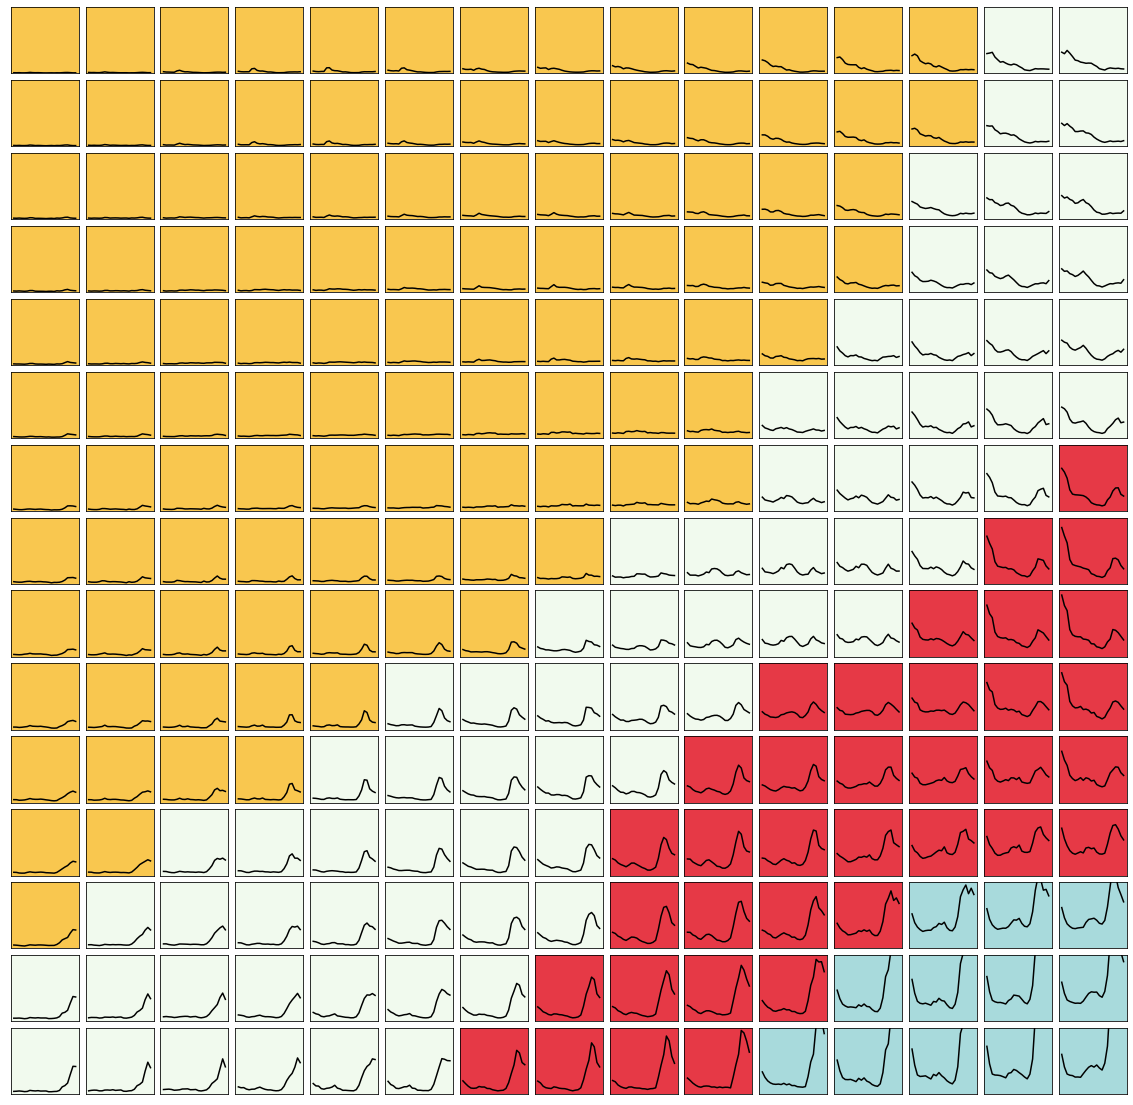

In [ ]:
graph_cluster(data=KMeans_all,W=weights,num_neurons=num_neurons, maxylim=np.max(data_talca))

## Pesos

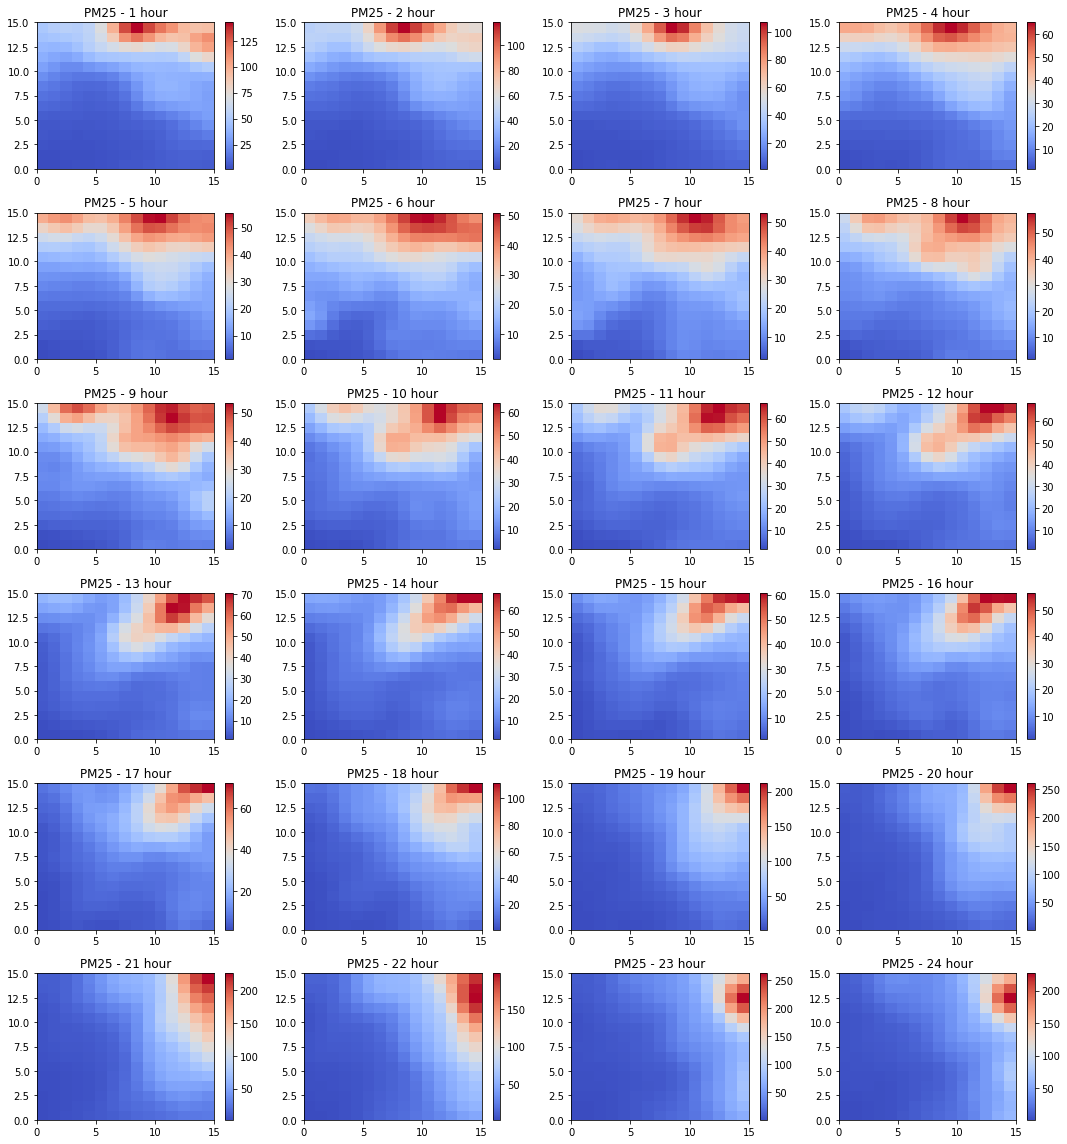

In [ ]:
graph_weights(weights, num_neurons)

###Save model

In [ ]:
## Save the model so that you do not need to train it again
with open('som_standard_15.pkl', 'wb') as f:
    pickle.dump(som_standard,f)

Se compara

# Pruebas

Experimento 1 : 
* Paso 1: tomar una instacia x y generar m mutantes,
* Paso 2: Identificar la neurona que representa a a la instacia x.
* paso 3: Para cada mutante hacer : Identificar a la neurona que representa a la mutante.
* Paso 4: El error es igual a la distancia que existe entre la neurona que representa a x y la neurona que representa a la mutante.
* Paso 5: reportar el error acumulado
 
 Comporar SOm y DTW-SOM usando experimento 1

 Supuesto preliminar:

 * DTW_SOM tiene menos error 
 * (*) La estadistica representa a mas de x. 


## Experimento 1

### Funciones del experimento

In [ ]:
def graph_perturbation_u_matrix(som,instance, ins_perturbate, data=[], show_data=False, col_names=[], show_target=False, jitter=True ,save_img=False, name_image='som_seed_pert'):
    w_x, w_y = zip(*[som.winner(d) for d in ins_perturbate]) ## obtener coordenadas de las perturbaciones
    w_x = np.array(w_x) ## vectores de las columnas de todas las neuronas que representan a las perturbaciones.
    w_y = np.array(w_y) ## idem para filas en la malla SOM

    w_x_ins, w_y_ins = zip(*[som.winner(instance)]) ### coordenadas de la BMU
    w_x_ins = np.array(w_x_ins)
    w_y_ins = np.array(w_y_ins)


    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
    plt.colorbar()

    colors = ['#0081a7', '#ff70a6', '#a7c957']

    if show_data:
        w_x_data, w_y_data = zip(*[som.winner(d) for d in data]) ## obtener coordenadas de los datos
        w_x_data = np.array(w_x_data) ## vectores de las columnas de todas las neuronas.
        w_y_data = np.array(w_y_data) ## idem para filas en la malla SOM
        if show_target:
            for c in np.unique(target):
                idx_target = target==c
                plt.scatter(w_x_data[idx_target]+(.5+(np.random.rand(np.sum(idx_target))-.5)*.8 if jitter else 0),
                            w_y_data[idx_target]+(.5+(np.random.rand(np.sum(idx_target))-.5)*.8 if jitter else 0), 
                            s=15, c=colors[c], label=label_names[c], alpha=.6)
        else:
            plt.scatter(w_x_data+(.5+(np.random.rand(data.shape[0])-.5)*.6 if jitter else 0),
                    w_y_data+(.5+(np.random.rand(data.shape[0])-.5)*.6 if jitter else 0), 
                    s=15, c='#888888', label="BMU instance", alpha=.3) 

    plt.scatter(w_x+(.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6 if jitter else 0),
                w_y+(.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6 if jitter else 0), 
                s=20, c='#ffbd00', label="BMU Perturbed Instances", alpha=.4) ## rand le da un a especie de Jitter para que no aparezcan en el mimos punto
    plt.scatter(w_x_ins+(.5+(np.random.rand(1)-.5)*.6 if jitter else 0),
                w_y_ins+(.5+(np.random.rand(1)-.5)*.6 if jitter else 0), 
                s=30, c='#d00000', label="BMU query instance", alpha=.8) 

    plt.legend(loc='upper right')
    plt.grid()
    if save_img:
        plt.savefig('images/'+str(name_image)+'.png')
    plt.show()

In [ ]:
def error_acumulado_dtw_som(instancia, modelo,ins_perturbed):

    # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = modelo.get_weights()[modelo.winner(instancia)] 

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [modelo.get_weights()[modelo.winner(ins)] for ins in ins_perturbed]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    error = 0
    for bmu_mutante in bmu_mutantes:
        error += dtw(bmu, bmu_mutante,global_constraint=gl_const,
                    sakoe_chiba_radius=scr)

    # 5- Calcula el error acumulado
    error_acum = error / len(ins_perturbed)

    return  error_acum

In [ ]:
def error_acumulado_som(instancia, modelo,ins_perturbed):
   # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = modelo.get_weights()[modelo.winner(instancia)] 

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [modelo.get_weights()[modelo.winner(ins)] for ins in ins_perturbed]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    distancias = np.array([fast_norm(bmu-bmu_mutante) for bmu_mutante in bmu_mutantes])

    # 5- Calcula el error acumulado
    error_acum = distancias.mean()

    return error_acum

In [ ]:
def error_acumulado_som_grid(instancia, modelo, ins_perturbed):
    # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = [np.asarray(modelo.winner(instancia)).tolist()] # modelo.quantization(np.array([instancia]))[0]

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [ [np.asarray(modelo.winner(np.array(ins))).tolist()] for ins in ins_perturbed]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    distancias = np.array([cdist(bmu, bmu_mutante, metric='cityblock') for bmu_mutante in bmu_mutantes])

    # 5- Calcula el error acumulado
    error_acum = distancias.mean()

    return error_acum

In [74]:
def method_validation(instance, ins_perturbed, som_standard=None, dtw_som=None):
        if(som_standard):
                errorE_som_standard= error_acumulado_som(instance, som_standard, ins_perturbed)
                print('Error som standard (Euclidean): ', errorE_som_standard)
                errorDTW_som = error_acumulado_dtw_som(instance, som_standard, ins_perturbed)
                print('Error som standard (DTW): ', errorDTW_som)
                error_som_standard = error_acumulado_som_grid(instance, som_standard, ins_perturbed)
                print('Error som standard (Grid): ', error_som_standard)
        if dtw_som:
                errorE_dtwsom = error_acumulado_som(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (Euclidean): ', errorE_dtwsom)
                errorDTW_dtwsom = error_acumulado_dtw_som(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (DTW): ', errorDTW_dtwsom)
                error_dtwsom = error_acumulado_som_grid(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (Grid): ', error_dtwsom)

In [ ]:
def method_validation_grid(instance, ins_perturbed, som_standard=None, dtw_som=None):
        if(som_standard):
                error_som_standard = error_acumulado_som_grid(instance, som_standard, ins_perturbed)
                print('Error som standard (Grid): ', error_som_standard)
        if dtw_som:
                error_dtwsom = error_acumulado_som_grid(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (Grid): ', error_dtwsom)

### Experimento SOM 30x30

In [ ]:
if os.path.exists('DTW-SOM/dtw_som.pkl'): # Busca modelo pre-entrenado en los archivos
  with open('DTW-SOM/dtw_som.pkl', 'rb') as f:  # abre el modelo pre-entrenado
    dtw_som = pickle.load(f) # Carga el modelo pre-entrenado

if os.path.exists('DTW-SOM/som_standard.pkl'): # Busca modelo pre-entrenado en los archivos
  with open('DTW-SOM/som_standard.pkl', 'rb') as f:  # abre el modelo pre-entrenado
    som_standard = pickle.load(f) # Carga el modelo pre-entrenado

#### Prueba Instancia 0

In [ ]:
idx_inst =0 
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)

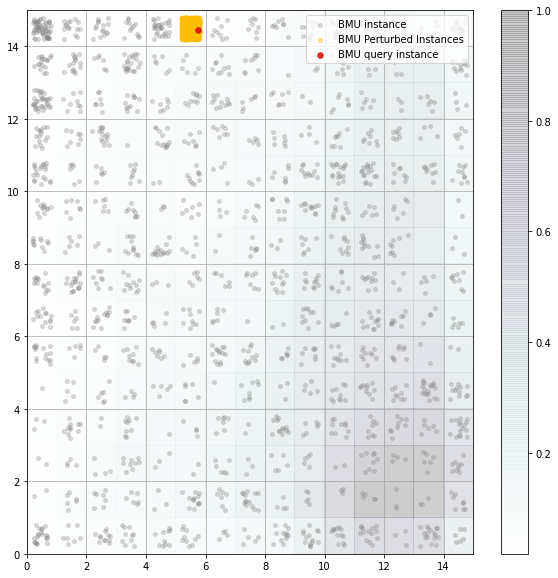

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

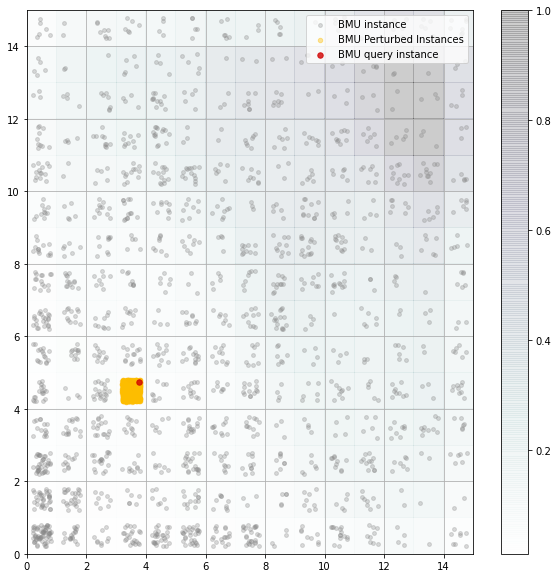

In [ ]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)




Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


#### instancia anómala 

In [ ]:
idx_inst =391
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-01-26T01:00:00.000000000')

In [ ]:
instance

array([  9.45   ,   9.45   ,   9.85001,   6.82   ,   3.02   ,   5.405  ,
         6.757  ,   5.405  ,   5.405  ,   6.757  ,   6.223  ,   7.196  ,
         8.11   , 410.8    , 447.3    , 525.8    , 766.2    , 602.7    ,
       344.6    , 215.9    , 155.1    ,  67.51   , 147.1    , 112.2    ])

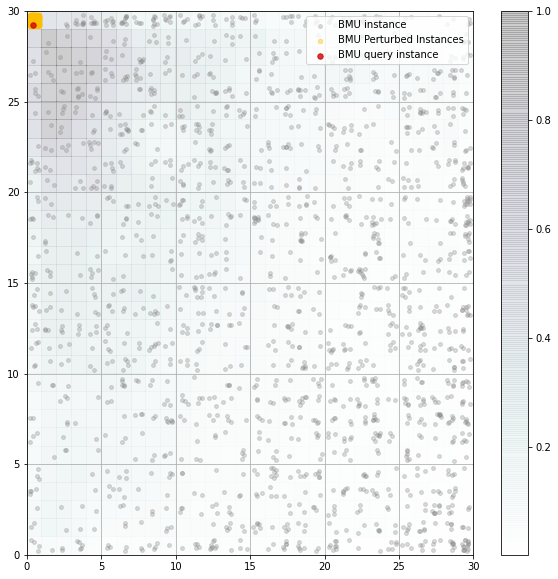

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

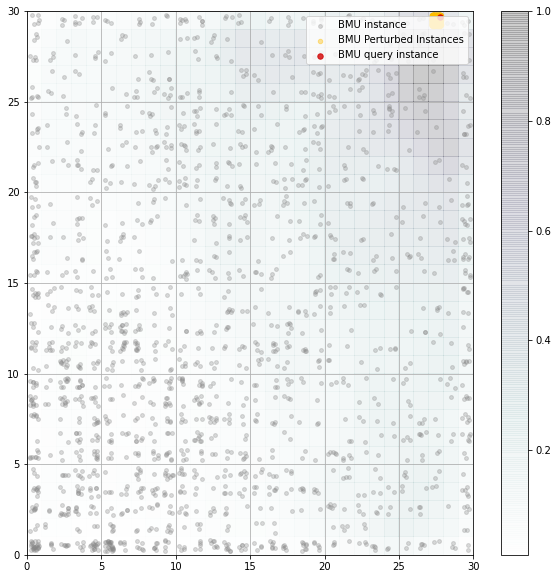

In [ ]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


#### Instancia 520 (2017-06-04 TALCA)

In [ ]:
idx_inst =520
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-06-04T01:00:00.000000000')

In [ ]:
instance

array([ 10.,  15.,  12.,  15.,  20.,  25.,  15.,  26.,  41.,  42.,  29.,
        15.,   4.,   4.,   4.,   7.,  15.,  32.,  29.,  45.,  39.,  45.,
       300., 132.])

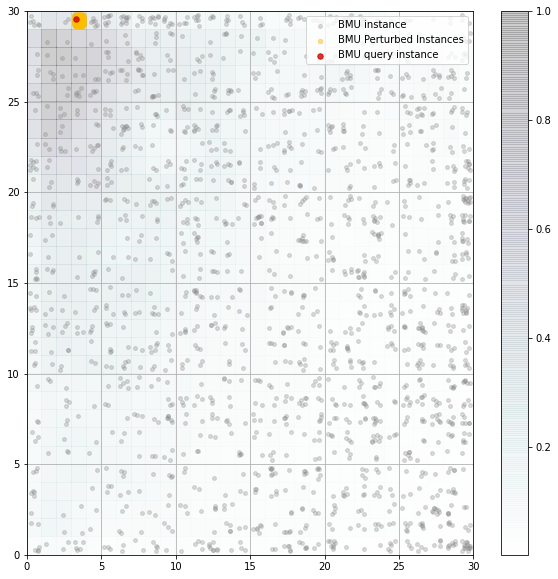

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

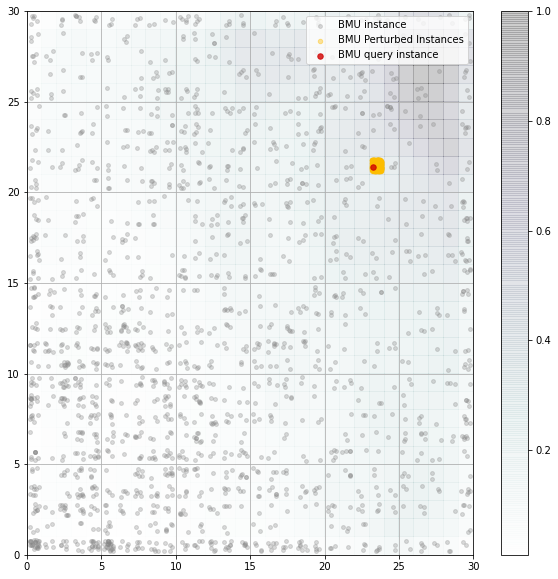

In [ ]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


### Pruebas SOM 15x15

In [54]:
if os.path.exists('DTW-SOM/dtw_som_15.pkl'): # Busca modelo pre-entrenado en los archivos
  with open('DTW-SOM/dtw_som_15.pkl', 'rb') as f:  # abre el modelo pre-entrenado
    dtw_som = pickle.load(f) # Carga el modelo pre-entrenado

if os.path.exists('DTW-SOM/som_standard_15.pkl'): # Busca modelo pre-entrenado en los archivos
  with open('DTW-SOM/som_standard_15.pkl', 'rb') as f:  # abre el modelo pre-entrenado
    som_standard = pickle.load(f) # Carga el modelo pre-entrenado

#### Instancia 520 (2017-06-04 TALCA)

In [62]:
idx_inst =520
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-06-04T01:00:00.000000000')

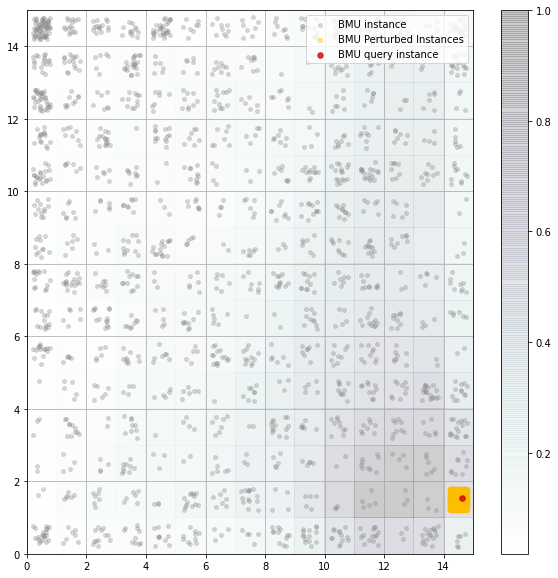

In [64]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

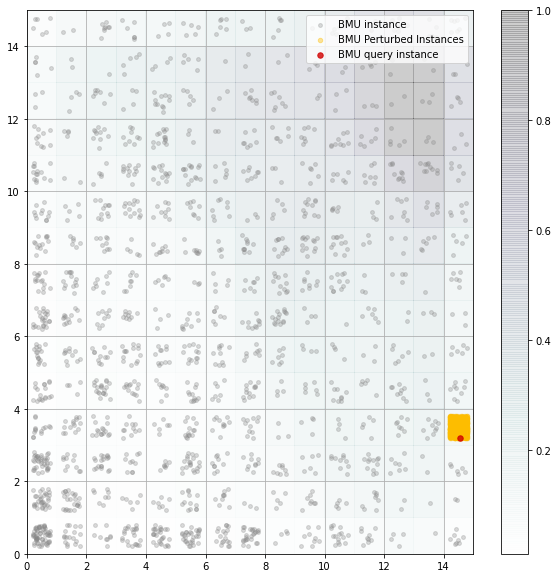

In [63]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [75]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (DTW):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


#### instancia anómala 

In [66]:
idx_inst =391
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-01-26T01:00:00.000000000')

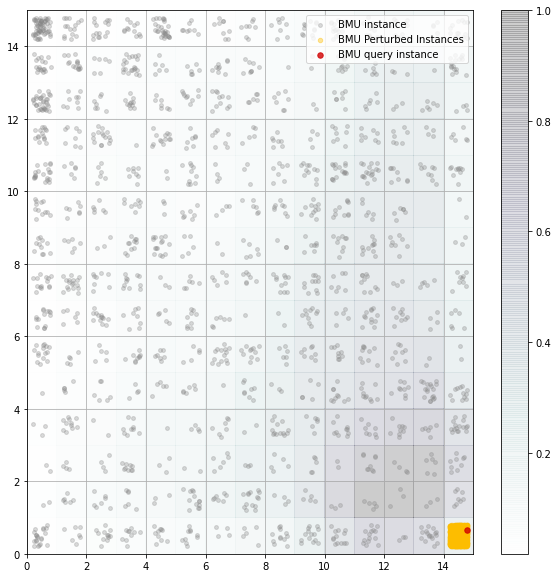

In [67]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

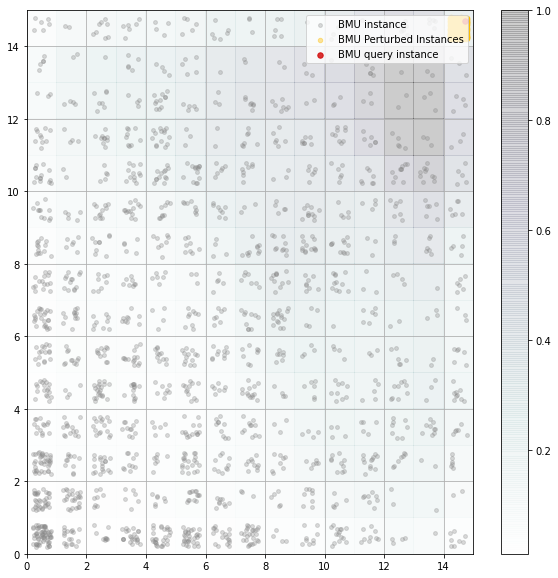

In [68]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [76]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (DTW):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


#### instancia 0

In [70]:
idx_inst =0 
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)

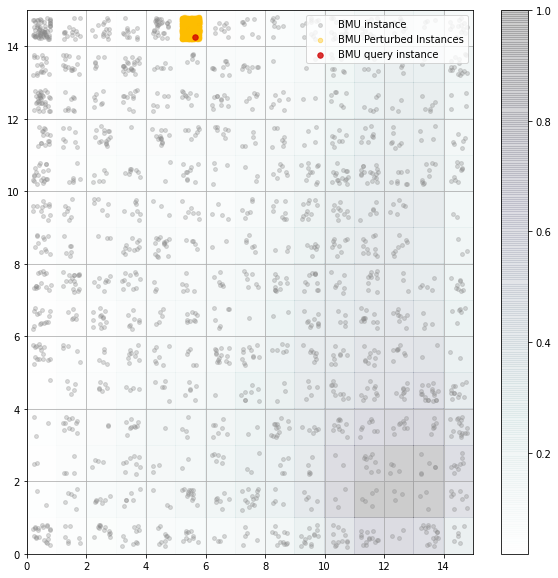

In [71]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

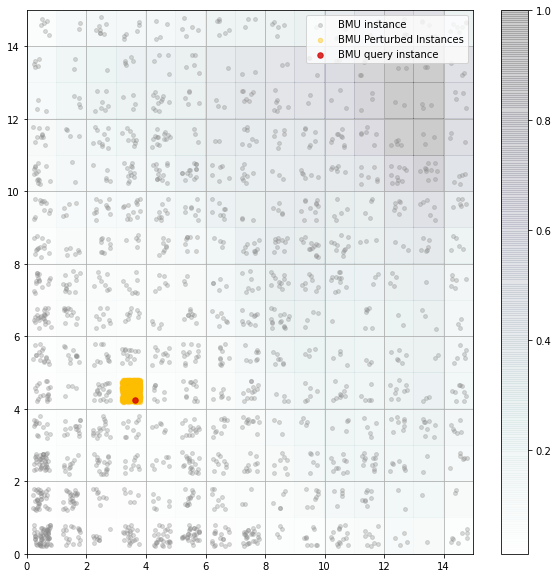

In [72]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [77]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (DTW):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


#### Instancia prueba

In [106]:
idx_inst =39
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2016-02-09T01:00:00.000000000')

In [107]:
instance

array([ 3.914  ,  2.709  ,  4.05   ,  5.356  ,  8.10999,  8.10999,
        6.327  ,  3.126  ,  2.635  ,  1.     ,  2.459  ,  5.381  ,
        6.77499,  6.41   ,  4.05399,  5.227  ,  5.477  ,  4.05399,
        2.689  ,  4.05199,  5.119  ,  6.847  , 10.49   ,  8.10999])

In [108]:
dtw_som.activation_response(ins_perturbed).T

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   6., 891.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0., 101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,

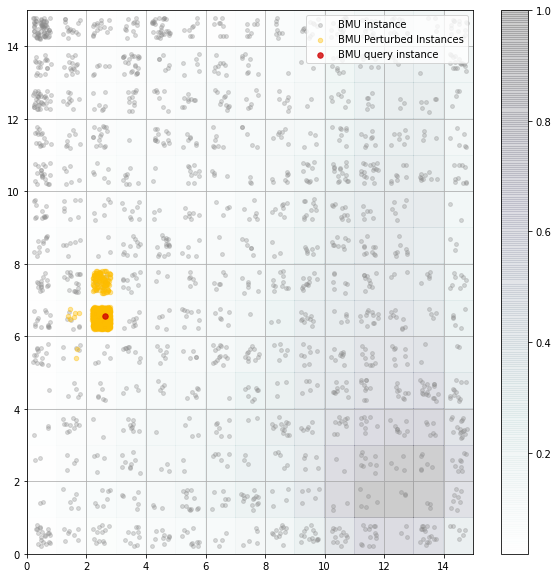

In [109]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [110]:
som_standard.activation_response(ins_perturbed).T

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,   

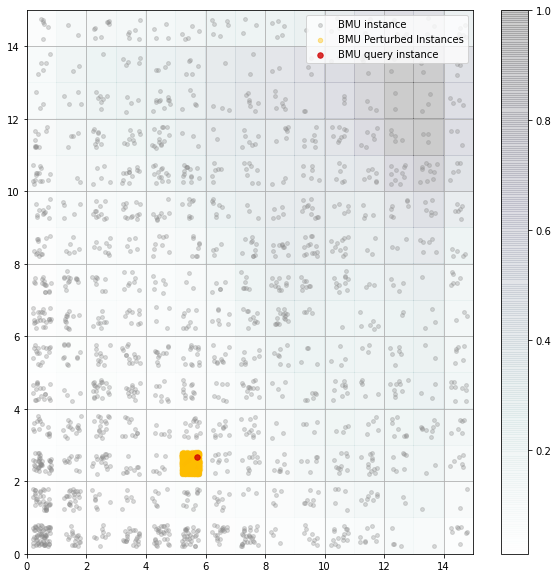

In [111]:
graph_perturbation_u_matrix(som_standard, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [112]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (DTW):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.770743269124725
Error DTW-SOM (DTW):  0.3223944351418207
Error DTW-SOM (Grid):  0.111


## Comparar modelos con todos los datos

Se crea un conjunto de datos completo de todas las 9 ciudades en el estudio, creando ventanas de datos de 24 horas.

In [46]:
def create_window_data_cities(df, cities, start_date="01-01-2016", end_date="31-12-2020"):
    start = datetime.datetime.strptime(start_date, "%d-%m-%Y") # Fecha inicial
    end = datetime.datetime.strptime(end_date, "%d-%m-%Y") # Fecha final
    date_generated = pd.date_range(start, end) # Genera las fechas entre la fecha inicial y final 

    data = [] # Array donde se almacena las ventanas de datos 
    index= [] # Array donde se almacena los indices de las ventanas  
    for city in cities: # Recorre el array de las ciudades dadas
        df_city = df.loc[df['city'] == city] # Selecciona los datos de una ciudad especifica
        del(df_city['city']) # Elimina la columna city 

        for day in date_generated: # Recorre el rango de fechas generados
            day_str = day.strftime("%m/%d/%Y") # Transforma la fecha al formato mm/dd/yy en string

             # Agrega el promedio de la primera ventana al primer valor porque
             # en todos las ciudades falta el PM25 del dia 01/01/2016 a las 00:00. 
            if ( day == start):
                data.append(np.append([[np.average(df_city.loc[day_str].values)]], df_city.loc[day_str].values))
            else:
                # Crea la ventana de datos para el dia y la agrega al array
                data.append(np.array(df_city.loc[day_str].values).reshape(1,24)[0])

            index.append([day_str, city]) # Añade el indices de la ventana en el array
            
    data = np.array(data) ## serie de tiempo
    index = np.array(index) ### este indice identifica el dia

    return (data, index) 



In [47]:
data_full, indexes = create_window_data_cities(frame, cities) # Crea las ventana de datos
data_full.shape

(16443, 24)

In [48]:
# Inicializa los parametros de SOM
num_neurons = round(sqrt(5*sqrt(len(data_full))))
sigma = 3 # radio
lr = 0.5 # tasa de aprendizaje
seed = 11 # semilla para repetir los resultados
num_iter = 8000 # numero de iteraciones para entrenar al SOM
input_len = data_full.shape[1] #Largo de la entrada

# Parámetros específicos SOM estándar
dist = 'euclidean' # Distancia utilizada 
neighborhood_funct = 'gaussian' # funcion de vencidad 

# Parámetros específicos de DTW-SOM
gl_const="sakoe_chiba"
scr=60

In [49]:
if os.path.exists('DTW-SOM/dtw_som_full.pkl'):
    with open('DTW-SOM/dtw_som_full.pkl', 'rb') as f:
        dtw_som_full = pickle.load(f)
else:
    dtw_som_full = dtwsom.DtwSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                        random_seed=seed, gl_const=gl_const, scr=scr)
    dtw_som_full.pca_weights_init(data_full)
    dtw_som_full.train_batch(data_full, num_iter, verbose=True)

## Save the model so that you do not need to train it again
with open('DTW-SOM/dtw_som_full.pkl', 'wb') as f:
    pickle.dump(dtw_som_full,f)

In [ ]:
print("Quantization Error (DTW-SOM): ",dtw_som_full.quantization_error(data_full))

Quantization Error (DTW-SOM):  40.284115633448245


In [50]:
if os.path.exists('DTW-SOM/som_full.pkl'):
    with open('DTW-SOM/som_full.pkl', 'rb') as f:
        som_full = pickle.load(f)
else:
    som_full = dtwsom.MiniSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                    random_seed=seed, neighborhood_function=neighborhood_funct)
    som_full.pca_weights_init(data_full)
    som_full.train_batch(data_full, num_iter, verbose=True)
## Save the model so that you do not need to train it again
with open('DTW-SOM/som_full.pkl', 'wb') as f:
    pickle.dump(som_full,f)

print("Quantization Error (SOM): ",som_full.quantization_error(data_full))

Quantization Error (SOM):  60.619292065738755


In [51]:
def get_qe(data, cities, model_som, model_dtw_som, isScaler=False, scaler=None):
    qe_som, qe_dtwsom = [],[]
    for city in cities:
        data_city, indexes_t = create_window_data_cities(data, [city])
        if isScaler and scaler:
            data_city = scaler.transform(data_city)
        qe_som.append(model_som.quantization_error(data_city)),  
        qe_dtwsom.append(model_dtw_som.quantization_error(data_city))
        #print(city+" SOM QE: ",som_full.quantization_error(data_city) ,"     DTW-SOM QE: ", dtw_som_full.quantization_error(data_city))

    df_qe = {'SOM': qe_som, 'DTW_SOM': qe_dtwsom, "city":cities}
    return pd.DataFrame(df_qe )

In [52]:
get_qe(frame, cities, som_full, dtw_som_full)

KeyboardInterrupt: ignored

El error de quantization 

In [53]:
def get_distance_error(data, cities, model_som, model_dtw_som, idx_inst=None, num_muta=100, mu=0, sigma=0.1, isScaler=False, scaler=None):
    e_som_eu, e_dtwsom_eu,e_som_dtw, e_dtwsom_dtw, e_som_grid,  e_dtwsom_grid = [],[],[],[],[],[]
    for city in cities:
        data_city, indexes_t = create_window_data_cities(data, [city])

        if not idx_inst:
            idx_inst = np.random.randint(data_city.shape[0]) 

        instance = data_city[idx_inst]
        # Generación de instancias perturbadas manualmente
        ins_perturbed = scaler.transform(perturbationByInstance(instance, num_muta, mu, sigma)) if isScaler and scaler else perturbationByInstance(instance, num_muta, mu, sigma)

        if isScaler and scaler:
            instance = scaler.transform([data_city[idx_inst]])[0]

        e_som_eu.append(error_acumulado_som(instance, model_som, ins_perturbed))  
        e_dtwsom_eu.append(error_acumulado_som(instance, model_dtw_som, ins_perturbed))
        e_som_dtw.append(error_acumulado_dtw_som(instance, model_som, ins_perturbed))
        e_dtwsom_dtw.append(error_acumulado_dtw_som(instance, model_dtw_som, ins_perturbed)) 
        e_som_grid.append(error_acumulado_som_grid(instance, model_som, ins_perturbed))
        e_dtwsom_grid.append(error_acumulado_som_grid(instance, model_dtw_som, ins_perturbed))

    df_error = {'SOM (Euclidean)': e_som_eu, 'DTW_SOM (Euclidean)': e_dtwsom_eu,
                'SOM (DTW)': e_som_dtw, 'DTW_SOM (DTW)': e_dtwsom_dtw,
        'SOM (Grid)': e_som_grid,'DTW_SOM (Grid)': e_dtwsom_grid,"city":cities}
    return pd.DataFrame(df_error)



In [ ]:
get_distance_error(frame, cities, som_full, dtw_som_full)

,SOM (Euclidean),DTW_SOM (Euclidean),DTW_SOM (DTW),SOM (Grid),DTW_SOM (Grid),city
0,0.000000,0.000000,0.000000,0.00,0.00,chillan
1,0.000000,0.000000,0.000000,0.00,0.00,curico
2,2.516776,0.404735,0.197568,0.55,0.02,linares
3,0.000000,1.928495,1.049706,0.00,0.36,los_angeles
4,0.060577,0.000000,0.000000,0.06,0.00,osorno
5,0.000000,0.000000,0.000000,0.00,0.00,puerto_montt
6,0.000000,0.000000,0.000000,0.00,0.00,rancagua
7,0.000000,0.000000,0.000000,0.00,0.00,san_fernando
8,0.000000,0.000000,0.000000,0.00,0.00,talca


Esta tabla resume los resultados de entrenar el mapa auto organizativo SOM y DTW-SOM con todos los datos de la ciudades disponibles.

En este experimento, para cada ciudad, se escoge al azar un día y se perturba, generando 100 mutantes. 

Se calculó la neurona ganadora para la instancia seleccionada, y luego se calculó la neurona ganadora para cada una de las instancias perturbadas. Para cada ciudad se estableció un error promedio, lo que se muestra en la tabla.

En aquellos casos donde el error es cero, quiere decir que todas las mutantes quedaban asignadas a la misma neurona ganadora que había sido asignada la instancia original. 

Para el caso de Linares se observa que diste W son ofrece mucho mejores resultados en comparación a la malla SOM tradicional. 

De manera opuesta, en la ciudad de Los Ángeles se consiguieron mejores errores de cuantificación utilizando las mallas SOM.

Adicionalmente para la ciudad de Osorno se obtuvieron mejores resultados utilizando el modelo DTW-SOM.

Una posible justificación es la aleatoria edad empleada para escoger la instancia de cada ciudad.

Mi sugerencia es repetir el experimento para descartar esta posibilidad.

En una primera impresión no se ven grandes diferencias entre los dos modelos.



# Modelo LSTM

In [ ]:
data_talca, indexes = create_window_data_cities(frame, ["talca"]) # Crea las ventana de datos

In [ ]:
train = data_talca[:len(data_talca)-1] 

In [ ]:
test = []
for i in range(len(data_talca)-1):  
  test.append(data_talca[i+1])

In [ ]:
test =np.array(test)

In [ ]:
 test.shape

(1826, 24)

In [ ]:
train.shape

(1826, 24)

In [ ]:
trainX = np.reshape(train, (train.shape[0], 1, train.shape[1]))
testX = np.reshape(test, (test.shape[0], 1, test.shape[1]))

In [ ]:
trainX.shape

(1826, 1, 24)

In [ ]:
testX.shape

(1826, 1, 24)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 24]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

#X_train, y_train, X_test, y_test = ts_train_test_normalize(df, 24, 1, name_target="PM25", start_date_train="2016", end_date_train="2020", start_date_test="2020", end_date_test="2020")


model_LSTM.compile(loss="mse", optimizer="adam",  metrics=['accuracy'])
history = model_LSTM.fit(trainX, testX, epochs=1000,verbose=0)

In [ ]:
model_LSTM.evaluate(trainX, testX)

58/58 [==============================] - 2s 4ms/step - loss: 743.6965 - accuracy: 0.1408


[743.6964721679688, 0.14084520936012268]

In [ ]:
data_talca, indexes = create_window_data_cities(frame, ["talca"]) # Crea las ventana de datos

In [ ]:
idx_inst =0 
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)

In [ ]:
def get_predict(ins,  model, time_steps, sc=None):
  ins = ins.reshape(-1,1)
  if sc:
    ins = sc.transform(ins)
  predict = model_LSTM.predict(ins)
  if sc:
    predict = sc.inverse_transform(predict)
  predict = predict.reshape(1,time_steps)
  return predict

In [ ]:
instance_predict = get_predict(instance, model_LSTM, 24)

In [ ]:
X_train[0]

array([[11.98   ],
       [ 7.986  ],
       [ 3.993  ],
       [ 5.324  ],
       [ 5.24   ],
       [ 4.55499],
       [ 6.655  ],
       [ 7.904  ],
       [ 7.986  ],
       [ 7.876  ],
       [ 5.324  ],
       [ 5.324  ],
       [ 3.995  ],
       [ 4.521  ],
       [ 6.64899],
       [ 5.48   ],
       [ 6.653  ],
       [ 7.842  ],
       [ 5.324  ],
       [ 5.324  ],
       [ 5.324  ],
       [ 2.662  ],
       [ 1.342  ],
       [ 4.45699]])

In [ ]:
y_test[0]

array([12.])

In [ ]:
np.append(X_train[0], [[23.]])

array([11.98   ,  7.986  ,  3.993  ,  5.324  ,  5.24   ,  4.55499,
        6.655  ,  7.904  ,  7.986  ,  7.876  ,  5.324  ,  5.324  ,
        3.995  ,  4.521  ,  6.64899,  5.48   ,  6.653  ,  7.842  ,
        5.324  ,  5.324  ,  5.324  ,  2.662  ,  1.342  ,  4.45699,
       23.     ])

In [ ]:
model_LSTM.predict(np.append(X_train[0], [[23.]]).reshape(-1,1)).shape

(25, 1)

In [ ]:
instance_predict

array([[23.701069, 40.690945, 29.722363, 17.959097, 22.056305, 21.8054  ,
        19.724426, 25.9432  , 29.491531, 29.722363, 29.412659, 22.056305,
        22.056305, 17.965492, 19.61932 , 25.925938, 22.520145, 25.937458,
        29.316856, 22.056305, 22.056305, 22.056305, 13.456288,  8.33275 ]],
      dtype=float32)

In [ ]:
get_predict(ins_perturbed[0], model_LSTM, 24)

array([[23.846321, 40.65443 , 29.904537, 18.443668, 21.986446, 21.735317,
        20.210262, 26.163345, 29.359272, 29.874973, 29.28207 , 21.917297,
        22.128426, 17.34951 , 19.082827, 25.764404, 22.219303, 26.027649,
        29.060802, 21.63398 , 22.492165, 21.98895 , 13.480654,  7.749695]],
      dtype=float32)

In [ ]:
data_talca[idx_inst]

array([ 5.88099913, 11.98      ,  7.986     ,  3.993     ,  5.324     ,
        5.24      ,  4.55499   ,  6.655     ,  7.904     ,  7.986     ,
        7.876     ,  5.324     ,  5.324     ,  3.995     ,  4.521     ,
        6.64899   ,  5.48      ,  6.653     ,  7.842     ,  5.324     ,
        5.324     ,  5.324     ,  2.662     ,  1.342     ])

In [ ]:
r2_list = np.array([r2_score(instance_predict,get_predict(ins)) for ins in ins_perturbed])

In [ ]:
print ('Test R2.2: %.3f' %  r2_list.mean())

Test R2.2: 0.998


Al obtener la predicción de la instancia seleccionada y se calcula el R^2 entre los resultados señadala anteriormente con la prediccion de cada instancia perturbada, tomando el promedio de los R^2 obtenidos. El resultado obtenido para esta prueba fue de un r^2: 0.998. Lo cual nos da cuenta de que las predicciones de los perturbaciones fueron muy similares a la prediccion real. 

In [ ]:
## Save the model so that you do not need to train it again
with open('LSTM_talca.pkl', 'wb') as f:
    pickle.dump(model_LSTM, f)

INFO:tensorflow:Assets written to: ram://0d7b9ae9-9998-4087-aea9-4dbf96b5932e/assets


INFO:tensorflow:Assets written to: ram://0d7b9ae9-9998-4087-aea9-4dbf96b5932e/assets


In [ ]:
if os.path.exists('LSTM_talca.pkl'): # Busca modelo pre-entrenado en los archivos
    with open('LSTM_talca.pkl', 'rb') as f: # abre el modelo pre-entrenado
        model_test = pickle.load(f)

# Otros Experimentos (WIP)

# Experimento 3

Dividir los datos en 80% Training y 20% testing.
Con el 80% se entrena la malla son usando 15 neuronas de ancho.
Una vez que se tiene el modelo entrenado, se mide el error de cotización del 20% restante

Para ello se toma una instancia, se calcula la Best Maching Unit (BMU), qué es la neurona ganadora. Entonces se calcula la distancia euclidiana entre esas dos mediciones, esto es el peso de la instancia seleccionada y el peso de la neurona ganadora.

Finalmente se promedian todos estos errores para obtener un error promedio total.

Se esperaría que el modelo que usa DTW fuese mejor


In [ ]:
data_talca, index_talca = create_window_data_cities(frame, ["talca"], start_date="01-01-2016", end_date="31-12-2020")
data_talca.shape

(1827, 24)

In [ ]:
train_len = int (data_talca.shape[0] * 0.8)
train = data_talca[:train_len]
test = data_talca[train_len:]
print("shape train: ",train.shape,"\nshape test: ", test.shape)

shape train:  (1461, 24) 
shape test:  (366, 24)


In [ ]:
dtw_som_exp2 = dtwsom.DtwSom(15, 15, input_len, sigma=sigma, learning_rate=lr,
                        random_seed=seed, gl_const=gl_const, scr=scr) # Inicializa el modelo
dtw_som_exp2.pca_weights_init(train) # Inicializa los pesos con PCA
dtw_som_exp2.train_batch(train, 3000, verbose=True) # Entena el modelo 

 [ 3000 / 3000 ] 100% - 5.81 it/s - 0:00:00 left  - quantization error: 30.809901861427385


In [ ]:
som_exp2 = dtwsom.MiniSom(15, 15, input_len, sigma=sigma, learning_rate=lr,
                    random_seed=seed, neighborhood_function=neighborhood_funct)
som_exp2.pca_weights_init(train)
som_exp2.train_batch(train, 3000, verbose=True)

 [ 3000 / 3000 ] 100% - 1165.35 it/s - 0:00:00 left  - quantization error: 44.22292188971574


In [ ]:
def error_qe_average(modelo,data_test):  
    #Calcula la distancia/error que existe entre el peso de la instancia seleccionada y el peso de la neurona ganadora.
    error=[]
    error_dtw=[]
    for ins in data_test:
      # se identifica a la neurona que la representa (BMU) a la instancia.
      bmu = modelo.get_weights()[modelo.winner(ins)]
      # Calcula la distancia euclidiana entre el peso de la instancia seleccionada y el peso de la neurona ganadora.
      error.append(fast_norm(ins-bmu))
      error_dtw.append(dtw(ins, bmu,global_constraint=gl_const,
                    sakoe_chiba_radius=scr))

    error= np.array(error)
    error_dtw = np.array(error_dtw)

    # Calcula el error acumulado
    error_acum = error.mean()
    error_acum_dtw = error_dtw.mean()

    return error_acum, error_acum_dtw

In [ ]:
error_qe_average(som_exp2, test)

(36.89599218275336, 29.17338378549048)

In [ ]:
error_qe_average(dtw_som_exp2, test)

(44.32277038471921, 25.827277223504673)

# Experimento 4

Otro experimento que es posible realizar consiste en aumentar la desviación estándar en el parámetro de la perturbación de los datos para revisar cuál es el efecto que existe entre ambos modelos SOM

In [ ]:
data_full, indexes = create_window_data_cities(frame, cities) # Crea las ventana de datos


In [ ]:
if os.path.exists('DTW-SOM/dtw_som_full.pkl'):
    with open('DTW-SOM/dtw_som_full.pkl', 'rb') as f:
        dtw_som_full = pickle.load(f)
else:
    dtw_som_full = dtwsom.DtwSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                        random_seed=seed, gl_const=gl_const, scr=scr)
    dtw_som_full.pca_weights_init(data_full)
    dtw_som_full.train_batch(data_full, num_iter, verbose=True)

In [ ]:
if os.path.exists('DTW-SOM/som_full.pkl'):
    with open('DTW-SOM/som_full.pkl', 'rb') as f:
        som_full = pickle.load(f)
else:
    som_full = dtwsom.MiniSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                    random_seed=seed, neighborhood_function=neighborhood_funct)
    som_full.pca_weights_init(data_full)
    som_full.train_batch(data_full, num_iter, verbose=True)

In [ ]:
get_distance_error(frame, cities, som_full, dtw_som_full, sigma=0.2)

,SOM (Euclidean),DTW_SOM (Euclidean),SOM (DTW),DTW_SOM (DTW),SOM (Grid),DTW_SOM (Grid),city
0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,chillan
1,0.000000,12.336030,0.000000,5.582107,0.00,1.20,curico
2,2.196414,0.000000,1.606653,0.000000,0.32,0.00,linares
3,0.000000,1.675772,0.000000,0.487694,0.00,0.07,los_angeles
4,0.000000,0.000000,0.000000,0.000000,0.00,0.00,osorno
5,0.000000,0.000000,0.000000,0.000000,0.00,0.00,puerto_montt
6,0.000000,0.000000,0.000000,0.000000,0.00,0.00,rancagua
7,0.000000,0.000000,0.000000,0.000000,0.00,0.00,san_fernando
8,0.637549,0.000000,0.396759,0.000000,0.09,0.00,talca


In [ ]:
get_distance_error(frame, cities, som_full, dtw_som_full, sigma=0.5)

,SOM (Euclidean),DTW_SOM (Euclidean),SOM (DTW),DTW_SOM (DTW),SOM (Grid),DTW_SOM (Grid),city
0,2.935405,8.675700,2.836765,7.198149,0.25,0.35,chillan
1,0.000000,0.000000,0.000000,0.000000,0.00,0.00,curico
2,0.000000,5.843954,0.000000,2.313639,0.00,0.08,linares
3,0.000000,0.000000,0.000000,0.000000,0.00,0.00,los_angeles
4,0.000000,0.000000,0.000000,0.000000,0.00,0.00,osorno
5,0.000000,0.000000,0.000000,0.000000,0.00,0.00,puerto_montt
6,0.000000,0.000000,0.000000,0.000000,0.00,0.00,rancagua
7,0.000000,0.000000,0.000000,0.000000,0.00,0.00,san_fernando
8,1.510228,0.284639,1.099984,0.215814,0.04,0.03,talca


In [ ]:
get_distance_error(frame, cities, som_full, dtw_som_full, sigma=1)

,SOM (Euclidean),DTW_SOM (Euclidean),SOM (DTW),DTW_SOM (DTW),SOM (Grid),DTW_SOM (Grid),city
0,0.000000,0.084552,0.000000,0.020771,0.00,0.02,chillan
1,0.000000,5.243172,0.000000,4.120975,0.00,1.67,curico
2,5.361454,0.156371,4.654178,0.074337,1.82,0.01,linares
3,2.044980,7.308567,1.572619,3.715816,0.69,1.43,los_angeles
4,1.248777,5.195667,0.905760,2.590400,0.35,0.91,osorno
5,1.596734,4.528545,1.234464,2.448158,0.73,1.72,puerto_montt
6,2.744771,7.472737,2.420922,4.300034,0.33,0.75,rancagua
7,2.174694,42.620517,1.755046,11.643397,0.53,0.65,san_fernando
8,3.650546,6.325332,2.707715,2.979700,3.17,1.53,talca


In [ ]:
get_distance_error(frame, cities, som_full, dtw_som_full, sigma=5)

,SOM (Euclidean),DTW_SOM (Euclidean),SOM (DTW),DTW_SOM (DTW),SOM (Grid),DTW_SOM (Grid),city
0,8.242710,29.961845,6.802346,15.436881,1.48,3.61,chillan
1,12.825013,28.336926,11.321979,15.808191,1.33,1.94,curico
2,11.280698,29.505992,9.443247,17.174657,2.74,5.21,linares
3,12.012174,21.550949,9.597782,11.002879,2.15,2.35,los_angeles
4,3.862344,28.473019,3.134231,12.827353,0.35,1.49,osorno
5,4.605286,27.334100,4.087691,18.971944,0.62,1.59,puerto_montt
6,10.236016,32.755910,8.227849,16.215255,0.80,2.08,rancagua
7,18.044840,35.452182,11.112673,17.888859,2.91,4.98,san_fernando
8,8.427214,24.194144,5.674715,12.679539,2.49,3.93,talca


# Metodo Final

Validacion Dataset Perturbados (VDP_SOM)

In [ ]:
def VDP_SOM(data, model_som, model_predictor=None, sc=None , dtw=True, idx_inst=None, num_muta=100, mu=0, sigma=0.1):
    
    if not idx_inst:
        idx_inst = np.random.randint(data.shape[0]) 

    instance = data[idx_inst]
    # Generación de instancias perturbadas manualmente
    ins_perturbed =  perturbationByInstance(instance, num_muta, mu, sigma)

    if dtw:
      e_som = error_acumulado_dtw_som(instance, model_som, ins_perturbed)
    else:
      e_som = error_acumulado_som(instance, model_som, ins_perturbed)

    e_som_grid = error_acumulado_som_grid(instance, model_som, ins_perturbed)
    

    if model_predictor:
      get_predict(instance, model_predictor, sc )

    df_error = {'Error Distance': e_som, 'Error Distance (GRID)': e_som_grid}
    return pd.DataFrame(df_error)